# **LAB 02: LÀM VIỆC VÀ TRỰC QUAN HÓA DỮ LIỆU CHUỖI THỜI GIAN**

#### Môn học: Trực quan hóa dữ liệu

#### Nhóm: 5


## **A. Thu thập dữ liệu**




nhóm 5 lựa chọn bộ dữ liệu *U.S. Air Pollution* cho lab 01. Bộ dữ liệu được chia sẻ miễn phí trên nền tảng data.world. (Link dataset: https://data.world/data-society/us-air-pollution-data)

License: <a href="http://opendatacommons.org/licenses/dbcl/1.0/">Database: Open Database, Contents: Database Contents</a>


Bộ dữ liệu được thu thập bằng cách scraped từ database của trang U.S. EPA : https://aqsdr1.epa.gov/aqsweb/aqstmp/airdata/download_files.html


## **B. Khám phá dữ liệu**

### **Import các thư viện**

In [1]:
#!pip install pingouin
#!pip install category_encoders
#!pip install plotly
#!pip install yellowbrick

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
"""
import seaborn as sns

import plotly.offline as py
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import pingouin as pg #for ANOVA

#from sklearn.preprocessing import OneHotEncoder
from sklearn import decomposition
import category_encoders as ce
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
from scipy.stats import zscore
from yellowbrick.cluster import KElbowVisualizer
"""

%matplotlib inline  

### **Đọc file dữ liệu vào dataframe**

In [3]:
df=pd.read_csv("pollution_us_2000_2016.csv")
df.head()


,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,...,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


### **Tiền xử lý và khám phá dữ liệu**

Đầu tiên ta sẽ xóa dòng index của dataset.

In [4]:
df=df.drop(columns="Unnamed: 0")

**Số dòng** và **số cột** của bộ dữ liệu:

In [5]:
num_rows, num_cols = df.shape
print("Num rows: ", num_rows)
print("Num cols: ", num_cols)

Num rows:  1746661
Num cols:  28


**Ý nghĩa của mỗi dòng**: Thông tin về nồng độ NO2, O3, SO2, CO trong không khí ở một thành phố trong một ngày.

In [6]:
pd.set_option('display.max_columns', None)
df.head(1)

,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.0,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN


Kiểm tra xem có dòng nào bị trùng lặp hay không:

In [7]:
df.duplicated().sum()

5032

Thực hiện loại bỏ các dòng trùng lặp:

In [8]:
df=df.drop_duplicates()

In [9]:
df.head()

,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,22.958333,36.0,19,34,Parts per million,0.013375,0.032,10,27,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


**Ý nghĩa của mỗi cột**: 

- `State Code` : Mã tiểu bang.
- `County code` : Mã quận.
- `Site Num` : Số site ở mỗi quận.
- `Address`: Địa chỉ
- `State` : Tên tiểu bang.
- `County` : Tên quận
- `City` : Tên thành phố
- `Date Local` : Ngày thực hiện đo.


4 chất gây ô nhiễm không khí ($NO_2, O_3, SO_2$ và  $O_3$), ứng với mỗi chất có 5 cột giá trị. Ví dụ đối với $NO_2$:

- `NO2 Units` : đơn vị đo lường NO2
- `NO2 Mean` : trung bình nồng độ NO2 trong một ngày cụ thể.
- `NO2 AQI` : chỉ số chất lượng không khí được tính toán bởi NO2 trong một ngày cụ thể.
-   `NO2 1st Max Value` : Giá trị lớn nhất của nồng độ NO2 trong ngày.
- `NO2 1st Max Hour` : Thời gian mà nồng độ NO2 đạt giá trị lớn nhất.

Ta sẽ thực hiện chuẩn hóa tên các cột để thuận tiện hơn cho việc sử dụng về sau:

In [10]:
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

**Kiểu dữ liệu của mỗi cột:**

In [11]:
df.dtypes

State_Code             int64
County_Code            int64
Site_Num               int64
Address               object
State                 object
County                object
City                  object
Date_Local            object
NO2_Units             object
NO2_Mean             float64
NO2_1st_Max_Value    float64
NO2_1st_Max_Hour       int64
NO2_AQI                int64
O3_Units              object
O3_Mean              float64
O3_1st_Max_Value     float64
O3_1st_Max_Hour        int64
O3_AQI                 int64
SO2_Units             object
SO2_Mean             float64
SO2_1st_Max_Value    float64
SO2_1st_Max_Hour       int64
SO2_AQI              float64
CO_Units              object
CO_Mean              float64
CO_1st_Max_Value     float64
CO_1st_Max_Hour        int64
CO_AQI               float64
dtype: object

Cột `Date_Local` chưa có kiểu dữ liệu phù hợp, ta sẽ thực hiện chuyển kiểu dữ liệu về kiểm **datetime**

In [12]:
df['Date_Local'] = pd.to_datetime(df['Date_Local'], format='%Y-%m-%d')

Chuyển các cột `State_Code`, `County_Code` sang **string**

In [13]:
df[['State_Code', 'County_Code','Site_Num']]=df[['State_Code', 'County_Code','Site_Num']].astype(str)

**Kiểm tra giá trị bị thiếu:**

In [14]:
df.isna().sum()/df.shape[0]

State_Code           0.00000
County_Code          0.00000
Site_Num             0.00000
Address              0.00000
State                0.00000
County               0.00000
City                 0.00000
Date_Local           0.00000
NO2_Units            0.00000
NO2_Mean             0.00000
NO2_1st_Max_Value    0.00000
NO2_1st_Max_Hour     0.00000
NO2_AQI              0.00000
O3_Units             0.00000
O3_Mean              0.00000
O3_1st_Max_Value     0.00000
O3_1st_Max_Hour      0.00000
O3_AQI               0.00000
SO2_Units            0.00000
SO2_Mean             0.00000
SO2_1st_Max_Value    0.00000
SO2_1st_Max_Hour     0.00000
SO2_AQI              0.49973
CO_Units             0.00000
CO_Mean              0.00000
CO_1st_Max_Value     0.00000
CO_1st_Max_Hour      0.00000
CO_AQI               0.50010
dtype: float64

Có gần 50% giá trị bị thiếu ở 2 cột `SO2_AQI` và `CO_AQI`, ta tìm cách để điền các giá trị bị thếu ở 2 cột này. Thử kiểm tra độ tương quan của 2 thuộc tính này với các thuộc khác:

In [15]:
df.corr()[["SO2_AQI","CO_AQI"]]

,SO2_AQI,CO_AQI
NO2_Mean,0.295155,0.661453
NO2_1st_Max_Value,0.277796,0.612002
NO2_1st_Max_Hour,0.020904,0.057343
NO2_AQI,0.281254,0.614904
O3_Mean,-0.071260,-0.356409
O3_1st_Max_Value,0.034398,-0.179837
O3_1st_Max_Hour,0.028698,0.006956
O3_AQI,0.051849,-0.130517
SO2_Mean,0.828281,0.203056
SO2_1st_Max_Value,0.987755,0.148843


`SO2_AQI` có quan hệ tuyến tính với `SO2_1st_Max_Value` (hệ số tương quan=0.987755) và `CO_AQI` có quan hệ tuyến tính với `CO_1st_Max_Value` ((hệ số tương quan=0.998375))

Text(0, 0.5, 'CO_AQI')

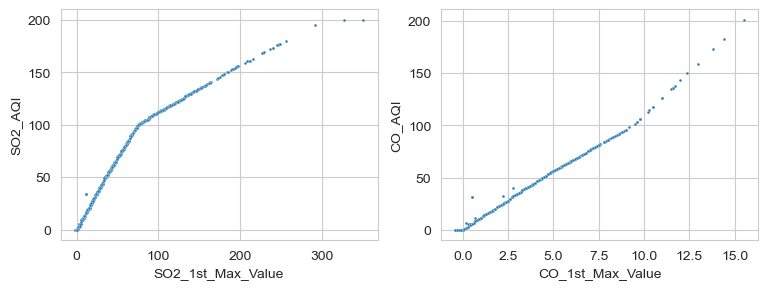

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(9,3))

sns.scatterplot(x=df["SO2_1st_Max_Value"], y=df["SO2_AQI"], ax=axs[0],s=3)
axs[0].set_xlabel("SO2_1st_Max_Value")
axs[0].set_ylabel("SO2_AQI")

sns.scatterplot(x=df["CO_1st_Max_Value"], y=df["CO_AQI"], ax=axs[1],s=3)
axs[1].set_xlabel("CO_1st_Max_Value")
axs[1].set_ylabel("CO_AQI")

Dữ liệu phân bố gần như trên một đường cong, ta sẽ xây dựng mô hình hồi quy bậc 2 để điền các giá trị thiếu trong `SO2_AQI` và `CO_AQI`:

In [17]:
existing_data_SO2 = df[df['SO2_AQI'].notna()]
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(existing_data_SO2['SO2_1st_Max_Value'].values.reshape(-1, 1))
y = existing_data_SO2['SO2_AQI'].values
model1 = LinearRegression()
model1.fit(X,y)
print(" R-squared score for SO2_AQI model: ",model1.score(X, y))

existing_data_CO = df[df['CO_AQI'].notna()]
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(existing_data_CO['CO_1st_Max_Value'].values.reshape(-1, 1))
y = existing_data_CO['CO_AQI'].values
model2 = LinearRegression()
model2.fit(X,y)

print(" R-squared score for CO_AQI model ",model2.score(X, y))

 R-squared score for SO2_AQI model:  0.9971336100583899
 R-squared score for CO_AQI model  0.9968621291603517


2 model cho kết tốt, thực hiện điền các giá trị thiếu:

In [18]:
df['SO2_AQI_pred'] = model1.predict(poly.fit_transform(df['SO2_1st_Max_Value'].values.reshape(-1, 1)))
df['SO2_AQI'] = np.where(df['SO2_AQI'].isnull(), df['SO2_AQI_pred'], df['SO2_AQI'])


df['CO_AQI_pred'] = model2.predict(poly.fit_transform(df['CO_1st_Max_Value'].values.reshape(-1, 1)))
df['CO_AQI'] = np.where(df['CO_AQI'].isnull(), df['CO_AQI_pred'], df['CO_AQI'])

df = df.drop(columns=['SO2_AQI_pred','CO_AQI_pred'])

**Phân bố giá trị của các cột numerical:**

Bảng thống kê cơ bản về các phân bố giá trị của các thuộc tính **numeric**:

In [19]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()


In [20]:
df[numeric_cols].describe().round(2)

,NO2_Mean,NO2_1st_Max_Value,NO2_1st_Max_Hour,NO2_AQI,O3_Mean,O3_1st_Max_Value,O3_1st_Max_Hour,O3_AQI,SO2_Mean,SO2_1st_Max_Value,SO2_1st_Max_Hour,SO2_AQI,CO_Mean,CO_1st_Max_Value,CO_1st_Max_Hour,CO_AQI
count,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00
mean,12.82,25.41,11.73,23.89,0.03,0.04,10.17,36.04,1.87,4.50,9.66,6.06,0.37,0.62,7.87,7.04
std,9.51,16.00,7.88,15.16,0.01,0.02,4.00,19.74,2.76,7.69,6.73,10.42,0.31,0.64,7.98,7.34
min,-2.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,-2.00,0.00,-3.20,-0.44,-0.40,0.00,-3.60
25%,5.75,13.00,5.00,12.00,0.02,0.03,9.00,25.00,0.26,0.90,5.00,0.65,0.18,0.29,0.00,3.00
50%,10.74,24.00,9.00,23.00,0.03,0.04,10.00,33.00,0.99,2.00,8.00,2.94,0.29,0.40,6.00,5.00
75%,17.71,35.60,20.00,33.00,0.03,0.05,11.00,42.00,2.33,5.00,14.00,7.00,0.47,0.80,13.00,9.00
max,139.54,267.00,23.00,132.00,0.10,0.14,23.00,218.00,321.62,351.00,23.00,200.00,7.51,19.90,23.00,210.01


**Phân bố giá trị của các cột categorical:**

In [21]:
df[set(df.columns)-set(numeric_cols)].describe()

,State,Date_Local,City,Address,CO_Units,NO2_Units,SO2_Units,County_Code,State_Code,O3_Units,County,Site_Num
count,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629
unique,47,5996,144,204,1,1,1,73,47,1,133,110
top,California,2013-04-17 00:00:00,Not in a city,PIKE AVE AT RIVER ROAD,Parts per million,Parts per billion,Parts per billion,13,6,Parts per million,Los Angeles,5
freq,575628,408,138375,35117,1741629,1741629,1741629,149178,575628,1741629,93371,76108
first,NaN,2000-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **C. Khám phá dữ liệu**

##### **Xu hướng của `CO_AQI`,`NO2_AQI`,`O3_AQI`,`SO2_AQI` theo `Date_Local` ở các `State`**

Xem xét các giá trị của cột `State`:

In [22]:
print("Number of States: ",df["State"].nunique())
print(df["State"].unique())

Number of States:  47
['Arizona' 'California' 'Colorado' 'District Of Columbia' 'Florida'
 'Illinois' 'Indiana' 'Kansas' 'Kentucky' 'Louisiana' 'Michigan'
 'Missouri' 'New Jersey' 'New York' 'North Carolina' 'Oklahoma'
 'Pennsylvania' 'Texas' 'Virginia' 'Massachusetts' 'Nevada'
 'New Hampshire' 'Tennessee' 'South Carolina' 'Connecticut' 'Iowa' 'Maine'
 'Maryland' 'Wisconsin' 'Country Of Mexico' 'Arkansas' 'Oregon' 'Wyoming'
 'North Dakota' 'Idaho' 'Ohio' 'Georgia' 'Delaware' 'Hawaii' 'Minnesota'
 'New Mexico' 'Rhode Island' 'South Dakota' 'Utah' 'Alabama' 'Washington'
 'Alaska']


Cột State chỉ có 47 giá trị khác nhau (đáng lẽ phải là 50 - tương ứng với 50 bang ở Mỹ), ta còn thấy thêm giá trị `Country Of Mexico` là không đúng, ta sẽ xóa những dòng này. 

In [23]:
df = df[df['State'] != 'Country Of Mexico']

Bộ dữ liệu có khá nhiều ngày nên để nhanh chóng trong việc phân tích và trực quan, ta sẽ thực hiện gom nhóm theo tuần (Lấy ngày đầu tiên trong tuần và giá trị của nó sẽ là trung bình giá trị các ngày còn lại trong tuần đó).

In [24]:
df_weekly = df.groupby([pd.Grouper(key='Date_Local', freq='W'),'State']).mean().reset_index()
df_weekly.head(2)

,Date_Local,State,NO2_Mean,NO2_1st_Max_Value,NO2_1st_Max_Hour,NO2_AQI,O3_Mean,O3_1st_Max_Value,O3_1st_Max_Hour,O3_AQI,SO2_Mean,SO2_1st_Max_Value,SO2_1st_Max_Hour,SO2_AQI,CO_Mean,CO_1st_Max_Value,CO_1st_Max_Hour,CO_AQI
0,2000-01-02,Arizona,25.166667,57.000000,20.0,55.166667,0.018083,0.034667,9.666667,29.333333,1.873264,3.291667,10.083333,4.601153,0.654474,1.650000,15.416667,18.812166
1,2000-01-02,California,12.958503,25.536585,11.0,24.097561,0.022383,0.032439,10.243902,27.585366,1.476579,2.619512,7.939024,3.537109,0.530950,1.146341,8.621951,13.024025


In [26]:
states = widgets.Dropdown(
    options=sorted(list(df_weekly['State'].unique())),
    value='New York',
    description='State: '
)

temp_df = df_weekly[df_weekly['State'] == 'New York']

trace1 = go.Scatter(x=temp_df["Date_Local"],y=temp_df["CO_AQI"], name='CO')
trace2 = go.Scatter(x=temp_df["Date_Local"],y=temp_df["NO2_AQI"], name='NO2')
trace3 = go.Scatter(x=temp_df["Date_Local"],y=temp_df["O3_AQI"],  name='O3')
trace4 = go.Scatter(x=temp_df["Date_Local"],y=temp_df["SO2_AQI"], name='SO2')
g = go.FigureWidget(data=[trace1, trace2,trace3,trace4],
                    layout=go.Layout(
                        title=dict(
                            text='Trend of AQI Weekly Pollutants by State'
                        ),
                    ))

def validate():
    if states.value in df_weekly['State'].unique():
        return True
    else:
        return False


def response(change):
    if validate():
        temp_df = df_weekly[df_weekly['State'] == states.value]
    
        with g.batch_update():  
            g.data[0].y = temp_df["CO_AQI"]
            g.data[1].y = temp_df["NO2_AQI"]
            g.data[2].y = temp_df["O3_AQI"]
            g.data[3].y = temp_df["SO2_AQI"]  
            
            g.data[0].x = temp_df["Date_Local"]     
            g.data[1].x = temp_df["Date_Local"] 
            g.data[2].x = temp_df["Date_Local"] 
            g.data[3].x = temp_df["Date_Local"]   



states.observe(response, names="value")

container = widgets.HBox([states])
widgets.VBox([container,g])

Nhìn chung ta thấy O3 là chất khí hàng đầu gây ô nhiễm trong các năm qua. Chỉ số O3_AQI luôn cao hơn NO2 AQI và cao hơn nhiều so với CO AQI và SO2 AQI

Chỉ số O3 AQI thường thì cao vào tháng 6,7 và thấp vào tháng 1,2,12, trong khi đó chỉ số SO2 AQI thường cao nhất vào tháng 11,12,1,2 và thấp nhất vào các tháng 6,7,8

Chỉ số SO2 AQI đang có xu hướng giảm dần.

#### **Air Quality Index (AQI) Basics**

![Air Quality Index](https://i.imgur.com/ZhqjZ03.png)

In [29]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Moderate"
    elif x <= 150:
        return "Unhealthy for Sensitive Groups"
    elif x <= 200:
        return "Unhealthy"
    elif x <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df["AQI_calculated"] = round(df[["CO_AQI", "NO2_AQI", "O3_AQI", "SO2_AQI"]].max(axis = 1))
df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df.head(1)

,State_Code,County_Code,Site_Num,Address,State,County,City,Date_Local,NO2_Units,NO2_Mean,NO2_1st_Max_Value,NO2_1st_Max_Hour,NO2_AQI,O3_Units,O3_Mean,O3_1st_Max_Value,O3_1st_Max_Hour,O3_AQI,SO2_Units,SO2_Mean,SO2_1st_Max_Value,SO2_1st_Max_Hour,SO2_AQI,CO_Units,CO_Mean,CO_1st_Max_Value,CO_1st_Max_Hour,CO_AQI,AQI_calculated,AQI_bucket_calculated
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.0,9.0,21,13.0,Parts per million,1.145833,4.2,21,47.682998,48.0,Good


In [30]:
df_AQI_bucket=pd.DataFrame(df["AQI_bucket_calculated"].value_counts().rename("count")).reset_index().rename(columns={"index":"AQI_bucket_calculated"})
color_map = {
    'Good': 'background-color: #21d918',
    'Moderate': 'background-color: yellow',
    'Unhealthy for Sensitive Groups': 'background-color: orange',
    'Unhealthy': 'background-color: red',
    'Very Unhealthy': 'background-color: purple',
    'Hazardous': 'background-color: maroon'
}
def apply_color(row):
    return [color_map[row["AQI_bucket_calculated"]]]

df_AQI_bucket=df_AQI_bucket.style.apply(apply_color, axis=1,subset=["AQI_bucket_calculated"])

In [31]:
display(df_AQI_bucket)

,AQI_bucket_calculated,count
0,Good,1467344
1,Moderate,226378
2,Unhealthy for Sensitive Groups,34449
3,Unhealthy,3680
4,Very Unhealthy,272


In [32]:
df_AQI_bucket_yearly=pd.DataFrame(df.groupby([pd.Grouper(key='Date_Local', freq='Y'),'State'])["AQI_bucket_calculated"].value_counts()).rename(columns={"AQI_bucket_calculated":"count"}).reset_index()
df_AQI_bucket_yearly["Date_Local"]=df_AQI_bucket_yearly["Date_Local"].dt.year
df_AQI_bucket_yearly=pd.pivot_table(df_AQI_bucket_yearly, values='count', index=['Date_Local', 'State'], columns=['AQI_bucket_calculated']).reset_index()

In [40]:
states_ = widgets.Dropdown(
    options=sorted(list(df_AQI_bucket_yearly['State'].unique())),
    value='New York',
    description='State: '
)

temp_df_ = df_AQI_bucket_yearly[df_AQI_bucket_yearly['State'] == 'New York']

trace1_ =go.Bar(name='Good', x=temp_df_['Date_Local'], y=temp_df_['Good'],marker={'color': "#21d918"})
trace2_ =go.Bar(name='Moderate', x=temp_df_['Date_Local'], y=temp_df_['Moderate'],marker={'color': "yellow"})
trace3_ =go.Bar(name='Unhealthy for Sensitive Groups', x=temp_df_['Date_Local'], y=temp_df_['Unhealthy for Sensitive Groups'],marker={'color': "orange"})
trace4_ =go.Bar(name='Unhealthy', x=temp_df_['Date_Local'], y=temp_df_['Unhealthy'],marker={'color': "red"})
trace5_ =go.Bar(name='Very Unhealthy', x=temp_df_['Date_Local'], y=temp_df_['Very Unhealthy'],marker={'color': "purple"})

g_ = go.FigureWidget(data=[trace1_,trace2_,trace3_,trace4_,trace5_],
                    layout=go.Layout(
                        title=dict(
                            text='Air Quality Index (AQI) By Year '
                        ),
                    ))

g_.update_xaxes(dtick=1)

def validate2():
    if states_.value in df_AQI_bucket_yearly['State'].unique():
        return True
    else:
        return False


def response_(change):
    if validate():
        temp_df_ = df_AQI_bucket_yearly[df_AQI_bucket_yearly['State'] == states_.value]
    
        with g_.batch_update():  
            g_.data[0].y = temp_df_['Good']
            g_.data[0].x = temp_df_["Date_Local"]     

            g_.data[1].y = temp_df_['Moderate']
            g_.data[1].x = temp_df_["Date_Local"]   
            
            g_.data[2].y = temp_df_['Unhealthy for Sensitive Groups']
            g_.data[2].x = temp_df_["Date_Local"]   
            
            g_.data[3].y = temp_df_['Unhealthy']
            g_.data[3].x = temp_df_["Date_Local"]   
            
            g_.data[4].y = temp_df_['Very Unhealthy']
            g_.data[4].x = temp_df_["Date_Local"]   


states_.observe(response_, names="value")

container_ = widgets.HBox([states_])
widgets.VBox([container_,g_])

In [60]:
df_states=df_AQI_bucket_yearly.groupby(["State"]).sum().drop(columns="Date_Local")
df_states.style.highlight_max(color = 'lightgreen', axis = 0)

AQI_bucket_calculated,Good,Moderate,Unhealthy,Unhealthy for Sensitive Groups,Very Unhealthy
State,,,,,
Alabama,2816.000000,286.000000,0.000000,24.000000,0.000000
Alaska,1914.000000,60.000000,0.000000,0.000000,0.000000
Arizona,52516.000000,16546.000000,0.000000,778.000000,0.000000
Arkansas,32011.000000,2954.000000,0.000000,152.000000,0.000000
California,489189.000000,70831.000000,1864.000000,13626.000000,118.000000
Colorado,26341.000000,8500.000000,2.000000,281.000000,0.000000
Connecticut,26575.000000,2708.000000,48.000000,602.000000,0.000000
Delaware,3148.000000,410.000000,0.000000,72.000000,0.000000
District Of Columbia,21551.000000,3535.000000,40.000000,566.000000,4.000000


## **D. Xây dựng mô hình học máy:**

### **1. Chuẩn bị dữ liệu**: 

### **2. Xây dựng mô hình**

### **3. Trực quan hóa mô hình:**

## **E. Tài liệu tham khảo**

....

https://www.kaggle.com/code/rohanrao/calculating-aqi-air-quality-index-tutorial#O3-(Ozone-or-Trioxygen)